# **Monte-Carlo Simulations to compute VaR and Expected Shortfall**

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# Settings the figsize parameter for the plots in this notebook to standardize the size of plots
plt.rcParams["figure.figsize"] = (10, 5)

In [2]:
stock_data=yf.download("NVDA", start="2010-01-01", end=dt.datetime.now().strftime("%Y-%m-%d"))
stock_data = stock_data.droplevel(1, axis=1)
stock_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,0.423807,0.426786,0.415097,0.424265,800204000
2010-01-05,0.429995,0.434580,0.422202,0.422202,728648000
2010-01-06,0.432746,0.433663,0.425640,0.429766,649168000
2010-01-07,0.424265,0.432287,0.421056,0.430454,547792000
2010-01-08,0.425182,0.428162,0.418306,0.420827,478168000


In [3]:
stock_data["Simple_returns"]=(stock_data["Close"]/stock_data["Close"].shift(1))-1
#Alternative way to calculate returns
# stock_data["pct_change"]=stock_data["Close"].pct_change() 
stock_data.tail(5)



Price,Close,High,Low,Open,Volume,Simple_returns
Date,,,,,,
2025-12-24,188.610001,188.910004,186.589996,187.940002,65528500,-0.003171
2025-12-26,190.529999,192.690002,188.000000,189.919998,139740300,0.010180
2025-12-29,188.220001,188.759995,185.910004,187.710007,120006100,-0.012124
2025-12-30,187.539993,188.990005,186.929993,188.240005,97687300,-0.003613
2025-12-31,186.500000,190.559998,186.490005,189.570007,120100500,-0.005545


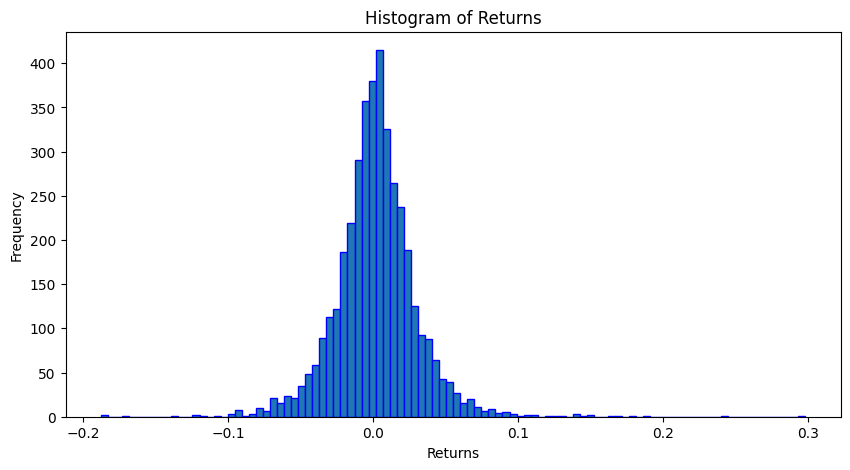

In [4]:
# Plotting the histogram of returns
plt.hist(stock_data["Simple_returns"].dropna(), bins=100, edgecolor='blue')
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.title("Histogram of Returns")
plt.show()



$\text{Average Annualized Return} = ( ( 1 + \mu ) ^ {252}) - 1$


Standard deviation for T time periods can be computed using the following formula:

$\sigma_{annual} = \sigma_{daily} * \sqrt{T}$

1. Compute the average daily returns and the annualized returns.
2. Compute the standard deviation of the returns and the annualized volatility.
3. Compute the annualized variance.
4. Compute the skewness and kurtosis of the returns.


In [5]:

avg_return=np.mean(stock_data["Simple_returns"])
std_dev_return= np.std(stock_data["Simple_returns"])
annualized_std_dev= std_dev_return * np.sqrt(252)
annualized_variance= annualized_std_dev **2
print("The standard deviation of return is: ", std_dev_return)
print("The daily average return is: ", avg_return)
print("The annualized standard deviation is: ", annualized_std_dev)
print("The annualized variance is: ", annualized_variance)  


The standard deviation of return is:  0.02878624284429538
The daily average return is:  0.001924914851004294
The annualized standard deviation is:  0.4569674384755092
The annualized variance is:  0.20881923982686829


In [6]:
import scipy.stats as stats
skewness=stats.skew(stock_data["Simple_returns"].dropna())
kurtosis=stats.kurtosis(stock_data["Simple_returns"].dropna(), fisher=True)
print("The skewness of returns is: ", skewness)
print("The kurtosis of returns is: ", kurtosis)

The skewness of returns is:  0.5650551247680088
The kurtosis of returns is:  8.127507370997314


In [7]:
# Import the shapiro function from the scipy.stats library
from scipy.stats import shapiro

# Compute the p_value by running the shapiro function on the returns column
t_stat, p_value = shapiro(stock_data["Simple_returns"].dropna())
print(t_stat,p_value)
# Print the results
if p_value <= 0.05:
    print("Null hypothesis of normality is rejected.")
else:
    print("Null hypothesis of normality is accepted.")

0.9328617784394305 3.047906485096763e-39
Null hypothesis of normality is rejected.


The historical VaR at 95% confidence level is: -0.04197603546126652
The historical Conditional VaR at 95% confidence level is: -0.061841632308017626
[-0.18755868 -0.18452121 -0.16968168 ...  0.18722739  0.24369617
  0.29806687]
[2.48570718e-04 4.97141437e-04 7.45712155e-04 ... 9.99502859e-01
 9.99751429e-01 1.00000000e+00]


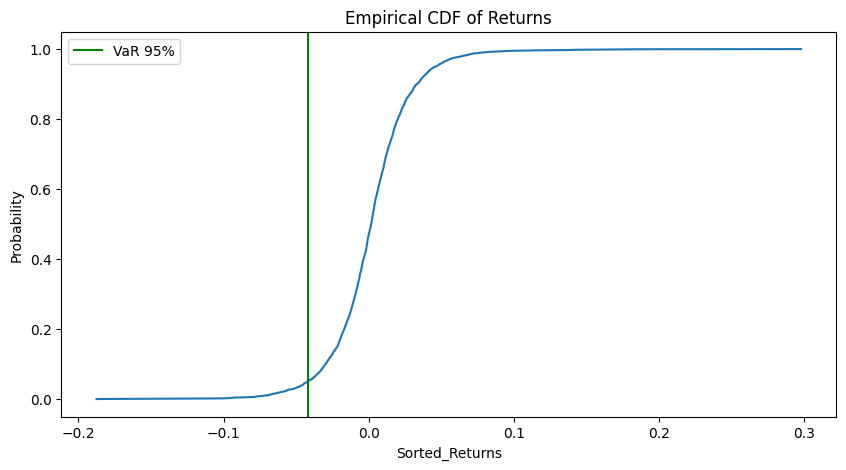

-0.04197603546126652


In [8]:
# Define the var level parameter
var_level = 95
significance_level = 1 - (var_level / 100)
# Compute and print the historical VaR
historical_var = np.percentile(stock_data["Simple_returns"].dropna(), significance_level * 100)
print(f"The historical VaR at {var_level}% confidence level is: {historical_var}")
historical_conditional_var = stock_data["Simple_returns"].dropna()[stock_data["Simple_returns"].dropna() <= historical_var].mean()
print(f"The historical Conditional VaR at {var_level}% confidence level is: {historical_conditional_var}")

# Sort the returns for plotting
sorted_returns = np.sort(stock_data["Simple_returns"].dropna())
probabilities = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)

print(sorted_returns)
print(probabilities)
# Plot the probability of each sorted return quantile
plt.plot(sorted_returns, probabilities)
plt.xlabel("Sorted_Returns")
plt.ylabel("Probability")
plt.title("Empirical CDF of Returns")

# Draw a vertical line in the plot for the VaR 95 quantile
plt.axvline(x=historical_var, color='g', linestyle='-', label=f'VaR {var_level}%')
plt.legend()
plt.show()
print(historical_var)


The Expected Shortfall at 95% confidence level is: -0.061841632308017626


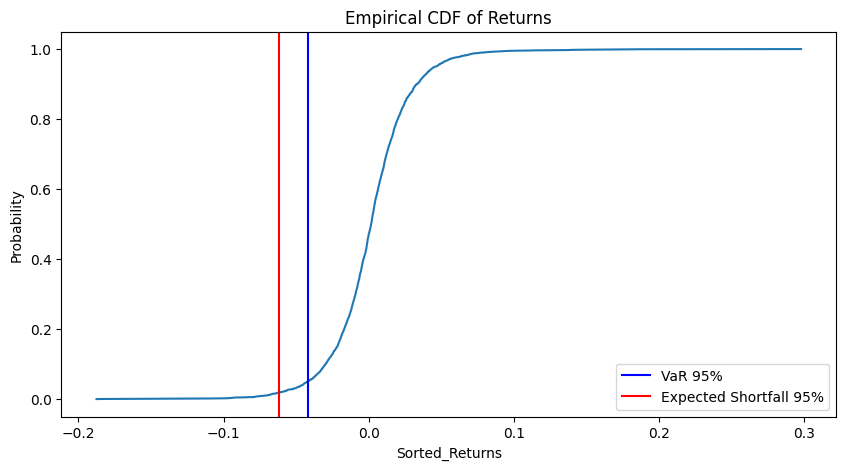

In [9]:
# Compute and print the expected shortfall with simple returns
Expected_Shortfall = stock_data["Simple_returns"].dropna()[stock_data["Simple_returns"].dropna() <= historical_var].mean()
print(f"The Expected Shortfall at {var_level}% confidence level is: {Expected_Shortfall}")

# Sort the returns for plotting
sorted_returns = np.sort(stock_data["Simple_returns"].dropna())
probabilities = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)

# Plot the probability of each sorted return quantile   
plt.plot(sorted_returns, probabilities)
plt.xlabel("Sorted_Returns")
plt.ylabel("Probability")
plt.title("Empirical CDF of Returns")   

# Draw vertical lines in the plot for the VaR 95 and CVaR quantiles
plt.axvline(x=historical_var, color='b', linestyle='-', label=f'VaR {var_level}%')
plt.axvline(x=Expected_Shortfall, color='r', linestyle='-', label=f'Expected Shortfall {var_level}%')
plt.legend()
plt.show()

### **Parametric VaR and C-VaR (Expected shortfall)**

The **parametric method VAR** (also known as **Variance/Covariance VAR**) calculation is another commonly used form of VaR calculation. This method allows you to simulate a range of possibilities based on historical return distribution properties rather than actual return values.


In [10]:
# Import the necessary library
from scipy.stats import norm

# Set the confidence level for VaR(95)
var_level = 95

# Set the significance level
significance_level = 1 - (var_level / 100)
# Calculate the parametric VaR(95)
parametric_var = norm.ppf(significance_level, loc=avg_return, scale=std_dev_return)
print(f"The parametric VaR at {var_level}% confidence level is: {parametric_var}")

# Calculate the parametric CVaR(95)
parametric_CVar = avg_return - (std_dev_return * norm.pdf(norm.ppf(significance_level)) / significance_level)
print(f"The parametric CVaR at {var_level}% confidence level is: {parametric_CVar}")                                                                

The parametric VaR at 95% confidence level is: -0.045424241097740826
The parametric CVaR at 95% confidence level is: -0.05745283694394278


### **Scaling the VaR**

The VaR calculated in the previous sections is simply the value at risk for a single day. To estimate the VaR for a longer time duration, scale the value by the square root of time, similar to scaling volatility.

The formula for this is:

 $\text{VaR}_{\text{t days}} = \text{VaR}_{\text{1 day}} * \sqrt{t}$


In [11]:
def plot_var(array):
  d = pd.DataFrame(abs(array))
  d[1].plot(xlabel='Time', ylabel='Forecasted VaR-95', title = "Time scaled VaR")
  plt.show()


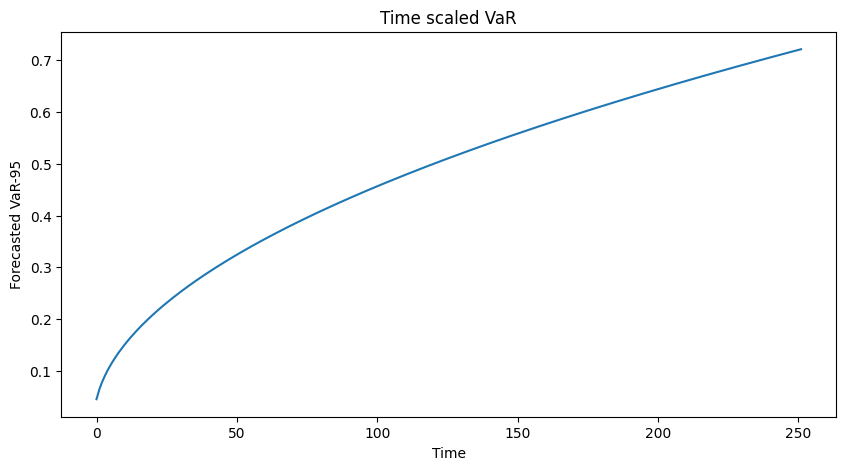

In [12]:
# Create an empty array to contain the VaR values
VaR_arr = np.empty((252, 2))

# Loop through the time period
for i in range(1, 253):
    VaR_arr[i-1, 0] = i
    VaR_arr[i-1, 1] = abs(parametric_var) * np.sqrt(i)

# Plot the results
plot_var(VaR_arr)


### **VaR(t)= _VaR computed above_ * np.sqrt(t).**

##### **Monte Carlo simulations**


In [13]:

np.random.seed(42)
stock_data["Log_returns"] = np.log(
    stock_data["Close"] / stock_data["Close"].shift(1)
)

log_returns = stock_data["Log_returns"].dropna()


mu = log_returns.mean()
var = log_returns.var()
sigma = log_returns.std()




Monte Carlo VaR (95%): -0.04503973806688406
Monte Carlo CVaR (95%): -0.05627130350753513


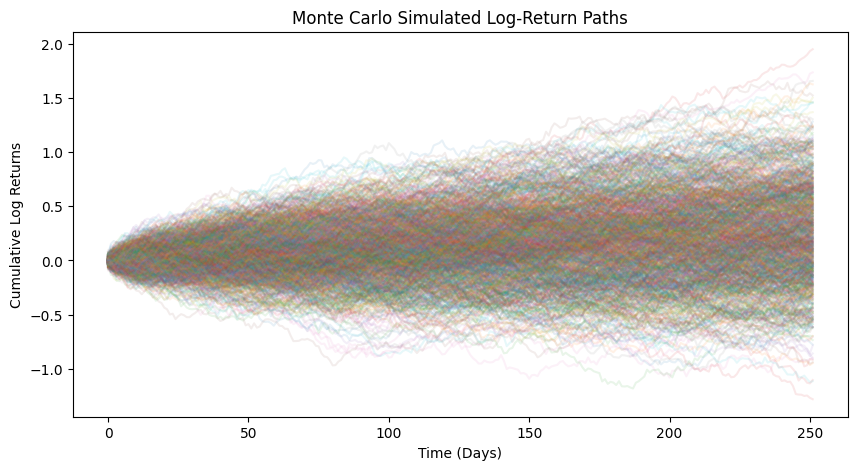

In [16]:


drift = mu - 0.5 * var

T = 252          # number of trading days
n_sims = 1000    # number of Monte Carlo simulations

random_shocks = np.random.normal(0, 1, (T, n_sims))

simulated_returns = drift + sigma * random_shocks

# Generate random shocks
z = np.random.normal(0, 1, (T, n_sims))

# Daily log returns
daily_returns = drift + sigma * z

# Convert to simple returns
returns_daily = np.exp(daily_returns) - 1


# Flatten all simulated returns
returns_flat = returns_daily.flatten()

# Monte Carlo VaR (95%)
mc_var = np.percentile(returns_flat, 5)

# Monte Carlo CVaR (95%)
mc_cvar = returns_flat[returns_flat <= mc_var].mean()

print("Monte Carlo VaR (95%):", mc_var)
print("Monte Carlo CVaR (95%):", mc_cvar)


plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(daily_returns, axis=0), alpha=0.1)
plt.title("Monte Carlo Simulated Log-Return Paths")
plt.xlabel("Time (Days)")
plt.ylabel("Cumulative Log Returns")
plt.show()



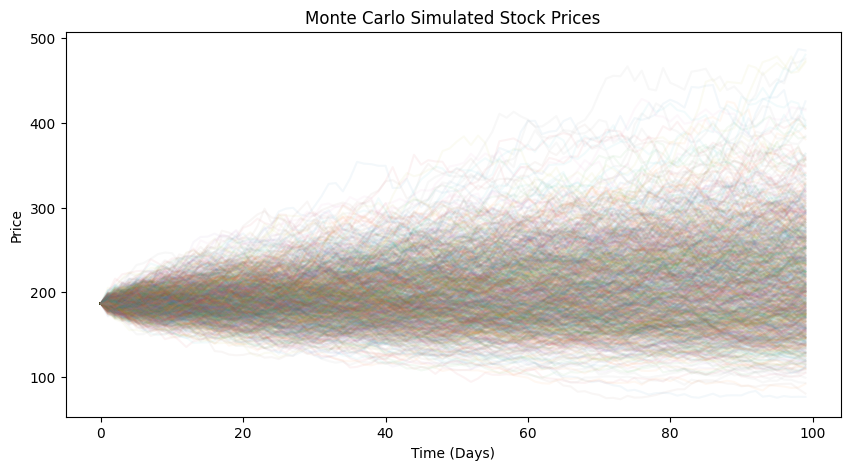

In [17]:

s0 = stock_data["Close"].iloc[-1]

n_days = 100
n_sims = 1000


price_paths = np.zeros((n_days, n_sims))
price_paths[0] = s0

for t in range(1, n_days):
    z = np.random.normal(0, 1, n_sims)
    price_paths[t] = price_paths[t-1] * np.exp(drift + sigma * z)


plt.figure(figsize=(10, 5))
plt.plot(price_paths, alpha=0.05)
plt.title("Monte Carlo Simulated Stock Prices")
plt.xlabel("Time (Days)")
plt.ylabel("Price")
plt.show()
